# RAS Commander: Post-Processing Stored Maps

This notebook demonstrates how to automate the generation of stored floodplain map outputs (like `.tif` files for Depth, WSEL, and Velocity) using the `ras-commander` library. This is a common post-processing step that can be time-consuming to do manually for multiple plans.

## Workflow

1.  **Initialize Project**: Set up the HEC-RAS project.
2.  **Run Simulation**: Ensure a plan has been computed to generate base results.
3.  **Automate Post-Processing**: Use the new `RasMap.postprocess_stored_maps` function to:
    -   Modify the `.rasmap` file to include stored map definitions.
    -   Update plan flags to *only* run the floodplain mapping component.
    -   Execute the plan, which quickly generates the `.tif` files.
    -   Restore the original plan and `.rasmap` files, keeping the new map layers.
4.  **Verify Output**: Load and visualize one of the generated `.tif` files to confirm success.

# Install necessary packages if not already installed
!pip install --upgrade ras-commander
!pip install rasterio

In [1]:
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))
    
print("Loading ras-commander from local dev copy")

# Now try to import again
from ras_commander import *

# Verify we're loading from the local copy
import ras_commander
local_path = Path(ras_commander.__file__).parent.parent
print(f"ras-commander loaded from: {local_path}")
print(f"Expected local path: {rascmdr_directory}")
print(f"Successfully using local copy: {local_path == rascmdr_directory}")


Loading ras-commander from local dev copy
ras-commander loaded from: C:\GH\ras-commander-mappingbranch
Expected local path: C:\GH\ras-commander-mappingbranch
Successfully using local copy: True


# Install necessary packages if not already installed
!pip install --upgrade ras-commander
!pip install rasterio

In [2]:
import sys
from pathlib import Path
from ras_commander import *
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Step 1: Prepare the HEC-RAS Project

First, we'll use `RasExamples` to get the `BaldEagleCrkMulti2D` project. Then, we'll run **Plan 06** to ensure we have a base set of results to work with. If the results already exist, the execution will be skipped.

In [3]:
# If /example_projects/BaldEagleCrkMulti2D does not exist, extract it
project_path = Path("./example_projects/BaldEagleCrkMulti2D").resolve()

if not os.path.exists(project_path):
    project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")

# Initialize the RAS project
init_ras_project(project_path, "6.6")

# Define the plan to work with
plan_number = "06"

# Check if the plan's HDF results file already exists
plan_hdf_path = ras.project_folder / f"{ras.project_name}.p{plan_number}.hdf"
if not plan_hdf_path.exists():
    print(f"Results for Plan {plan_number} not found. Running the simulation first...")
    success = RasCmdr.compute_plan(plan_number, num_cores=4)
    if not success:
        raise RuntimeError(f"Initial computation of plan {plan_number} failed.")
    print(f"Plan {plan_number} successfully computed.")
else:
    print(f"Results for Plan {plan_number} already exist. Skipping initial computation.")

2025-06-19 13:58:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


Results for Plan 06 already exist. Skipping initial computation.


## Step 2: Use `postprocess_stored_maps` to Generate Floodplain Maps

Now we'll call the new function. It will handle all the file modifications, run HEC-RAS in mapping-only mode, and clean up afterwards.

In [4]:
ras.plan_df

plan_number unsteady_number geometry_number  \
0           13              07              06   
1           15              12              08   
2           17              09              10   
3           18              10              11   
4           19              11              12   
5           03              13              09   
6           04              01              13   
7           02              01              01   
8           01              01              01   
9           05              02              03   
10          06              03              09   

                                 Plan Title Program Version  \
0                   PMF with Multi 2D Areas            5.10   
1               1d-2D Dambreak Refined Grid            5.10   
2                           2D to 1D No Dam            5.00   
3                              2D to 2D Run            5.00   
4                    SA to 2D Dam Break Run            5.00   
5   Single 2D Area - Internal Dam Structure            5.04   
6   SA to 2D Area Conn - 2D Levee Structure            5.00   
7                  SA to Detailed 2D Breach            5.10   
8              SA to Detailed 2D Breach FEQ            5.03   
9           Single 2D area with Bridges FEQ            5.10   
10            Gridded Precip - Infiltration            6.00   

            Short Identifier                Simulation Date  \
0               PMF Multi 2D  01JAN1999,1200,04JAN1999,1200   
1         1D-2D Refined Grid  01JAN1999,1200,04JAN1999,1200   
2            2D to 1D No Dam  01JAN1999,1200,06JAN1999,1200   
3               2D to 2D Run  01JAN1999,1200,04JAN1999,1200   
4         SA to 2D Dam Break  01JAN1999,1200,04JAN1999,1200   
5                  Single 2D  01JAN1999,1200,04JAN1999,1200   
6             2D Levee Struc  01JAN1999,1200,04JAN1999,1200   
7             SA-2D Det Brch  01JAN1999,1200,04JAN1999,1200   
8              SA-2D Det FEQ  01JAN1999,1200,04JAN1999,1200   
9      Single 2D Bridges FEQ  01JAN1999,1200,04JAN1999,1200   
10  Grid Precip Infiltration  09SEP2018,0000,14SEP2018,0000   

   Computation Interval Mapping Interval Run HTab  ... DSS File  \
0                 30SEC            30MIN        1  ...      dss   
1                 20SEC             5MIN        1  ...      dss   
2                  1MIN             5MIN        1  ...      dss   
3                 20SEC             5MIN        1  ...      dss   
4                 20SEC            10MIN        1  ...      dss   
5                 30SEC            10MIN        1  ...      dss   
6                 20SEC             5MIN        1  ...      dss   
7                 10SEC             5MIN        1  ...      dss   
8                  5SEC             5MIN        1  ...      dss   
9                  5SEC            10MIN       -1  ...      dss   
10                20SEC            10MIN       -1  ...      dss   

   Friction Slope Method UNET D2 SolverType UNET D2 Name  \
0                      1   Pardiso (Direct)          193   
1                      1                NaN  BaldEagleCr   
2                      1                NaN   Upstream2D   
3                      1                NaN  BaldEagleCr   
4                      1                NaN  BaldEagleCr   
5                      1                NaN  BaldEagleCr   
6                      1                NaN  BaldEagleCr   
7                      1   Pardiso (Direct)  BaldEagleCr   
8                      1                NaN  BaldEagleCr   
9                      1   PARDISO (Direct)  BaldEagleCr   
10                     1   Pardiso (Direct)  BaldEagleCr   

                                     HDF_Results_Path Geom File  \
0                                                None        06   
1                                                None        08   
2                                                None        10   
3                                                None        11   
4                          

In [5]:
# NOTE: For HEC-RAS 5.0.7 projects being run in HEC-RAS 6.x, you must manually open Ras.exe and use RASMapper to generate easmapper entries.
# This step is only required for 5.0.7 projects run in 6.x.

In [6]:
import subprocess
import sys

# Print instructions to the user
print("\n" + "="*60)
print("MANUAL STEP REQUIRED: Update .rasmap to Version 6.x")
print("This project was created in HEC-RAS 5.0.7. To generate stored maps in HEC-RAS 6.x, you must:")
print("1. HEC-RAS will now be opened with this project.")
print("2. In HEC-RAS, open RAS Mapper (from the main toolbar).") 
print("3. When prompted, allow RAS Mapper to update the .rasmap file to the new version.")
print("4. Once the update is complete, close RAS Mapper and exit HEC-RAS.")
print("\nAfter closing HEC-RAS, return here and continue running the notebook.")
print("="*60 + "\n")

ras_exe = ras.ras_exe_path
prj_path = f'"{str(ras.prj_file)}"'  # Add quotes around project path

command = f"{ras_exe} {prj_path}"
print(command)

try:
    # Capture the process object so we can get its PID
    if sys.platform == "win32":
        hecras_process = subprocess.Popen(command)
    else:
        hecras_process = subprocess.Popen([ras_exe, prj_path])
    
    # Store the process ID for use in the next cell
    hecras_pid = hecras_process.pid
    print(f"Opened HEC-RAS with Process ID: {hecras_pid}")
    print("Please wait for the next cell to automate RAS Mapper...")
    
except Exception as e:
    print(f"Failed to launch HEC-RAS: {e}")
    hecras_pid = None



import win32gui
import win32con
import win32api
import win32com.client
import win32process
import time
import ctypes
from ctypes import wintypes

# Constants
WM_COMMAND = 0x0111
MIIM_STRING = 0x00000040
MIIM_ID = 0x00000002
MIIM_SUBMENU = 0x00000004
MIIM_TYPE = 0x00000010
MIIM_DATA = 0x00000020
MF_BYPOSITION = 0x00000400

def get_windows_by_pid(pid):
    """Find all windows belonging to a specific process ID"""
    def callback(hwnd, hwnds):
        if win32gui.IsWindowVisible(hwnd) and win32gui.IsWindowEnabled(hwnd):
            # Get the process ID for this window
            _, window_pid = win32process.GetWindowThreadProcessId(hwnd)
            if window_pid == pid:
                window_title = win32gui.GetWindowText(hwnd)
                if window_title:  # Only include windows with titles
                    hwnds.append((hwnd, window_title))
        return True
    
    hwnds = []
    win32gui.EnumWindows(callback, hwnds)
    return hwnds

def find_main_hecras_window(windows):
    """Find the main HEC-RAS window from a list of windows"""
    for hwnd, title in windows:
        # Main window usually has "HEC-RAS" in title and has a menu bar
        if "HEC-RAS" in title and win32gui.GetMenu(hwnd):
            return hwnd, title
    return None, None

def get_menu_string(menu_handle, pos):
    """Get menu item string at position"""
    # Create buffer for menu string
    buf_size = 256
    buf = ctypes.create_unicode_buffer(buf_size)
    
    # Get menu item info
    user32 = ctypes.windll.user32
    result = user32.GetMenuStringW(
        menu_handle,
        pos,
        buf,
        buf_size,
        MF_BYPOSITION
    )
    
    if result:
        return buf.value
    return ""

def enumerate_all_menus(hwnd):
    """Enumerate all menus and their items"""
    menu_bar = win32gui.GetMenu(hwnd)
    if not menu_bar:
        print("No menu bar found")
        return None
    
    menu_count = win32gui.GetMenuItemCount(menu_bar)
    print(f"\nFound {menu_count} top-level menus:")
    
    gis_tools_info = None
    
    for i in range(menu_count):
        # Get menu text
        menu_text = get_menu_string(menu_bar, i)
        print(f"\nMenu {i}: '{menu_text}'")
        
        # Get submenu handle
        submenu = win32gui.GetSubMenu(menu_bar, i)
        if submenu:
            item_count = win32gui.GetMenuItemCount(submenu)
            print(f"  Contains {item_count} items:")
            
            for j in range(item_count):
                item_text = get_menu_string(submenu, j)
                # Get menu item ID
                menu_id = win32gui.GetMenuItemID(submenu, j)
                print(f"    Item {j}: '{item_text}' (ID: {menu_id})")
                
                # Store GIS Tools info if found
                if "gis tools" in menu_text.lower():
                    if "ras mapper" in item_text.lower():
                        gis_tools_info = (submenu, menu_id, item_text)
    
    return gis_tools_info

def open_rasmapper_via_menu(hec_ras_hwnd):
    """Open RASMapper through HEC-RAS menu system"""
    try:
        # Enumerate all menus to find RAS Mapper
        gis_tools_info = enumerate_all_menus(hec_ras_hwnd)
        
        if gis_tools_info:
            submenu, menu_id, item_text = gis_tools_info
            print(f"\nFound RAS Mapper: '{item_text}' with ID: {menu_id}")
            
            # Send command to open RASMapper
            win32api.PostMessage(hec_ras_hwnd, WM_COMMAND, menu_id, 0)
            return True
        else:
            print("\nCould not find RAS Mapper in any menu")
            return False
            
    except Exception as e:
        print(f"Menu method failed with error: {e}")
        import traceback
        traceback.print_exc()
        return False

def open_rasmapper_keyboard(hwnd):
    """Alternative method using keyboard shortcuts"""
    try:
        shell = win32com.client.Dispatch("WScript.Shell")
        
        # More robust window activation
        # First, check if window is minimized and restore it
        if win32gui.IsIconic(hwnd):
            win32gui.ShowWindow(hwnd, win32con.SW_RESTORE)
            time.sleep(0.5)
        
        # Try multiple methods to bring window to foreground
        try:
            # Method 1: Direct SetForegroundWindow
            win32gui.SetForegroundWindow(hwnd)
        except:
            try:
                # Method 2: Use ShowWindow then SetForegroundWindow
                win32gui.ShowWindow(hwnd, win32con.SW_SHOW)
                win32gui.SetForegroundWindow(hwnd)
            except:
                # Method 3: Use BringWindowToTop
                win32gui.BringWindowToTop(hwnd)
        
        time.sleep(0.5)
        
        # Send Alt+G for GIS Tools menu
        shell.SendKeys("%g")
        time.sleep(0.2)
        
        # Send R for RAS Mapper
        shell.SendKeys("r")
        return True
    except Exception as e:
        print(f"Keyboard method failed: {e}")
        return False

def find_rasmapper_window():
    """Find any RAS Mapper window"""
    def callback(hwnd, windows):
        if win32gui.IsWindowVisible(hwnd) and win32gui.IsWindowEnabled(hwnd):
            window_title = win32gui.GetWindowText(hwnd)
            if "RAS Mapper" in window_title:
                windows.append((hwnd, window_title))
        return True
    
    windows = []
    win32gui.EnumWindows(callback, windows)
    return windows

def close_rasmapper():
    """Close RASMapper window"""
    windows = find_rasmapper_window()
    
    for hwnd, title in windows:
        try:
            win32gui.PostMessage(hwnd, win32con.WM_CLOSE, 0, 0)
            print(f"Closed: {title}")
            return True
        except:
            continue
    return False

def wait_for_window(find_window_func, timeout=60, check_interval=2):
    """Wait for a window to appear"""
    start_time = time.time()
    while time.time() - start_time < timeout:
        windows = find_window_func()
        if windows:
            return windows
        print(f"Window not found, waiting {check_interval} seconds...")
        time.sleep(check_interval)
    return None

# Main automation
if 'hecras_pid' not in globals() or hecras_pid is None:
    print("ERROR: HEC-RAS process ID not found. Please run the previous cell first.")
else:
    print(f"Looking for HEC-RAS windows for process ID: {hecras_pid}")
    print("Waiting for HEC-RAS to fully load...")
    
    # Wait for HEC-RAS window to appear
    windows = None
    while True:
        windows = get_windows_by_pid(hecras_pid)
        if windows:
            print(f"Found {len(windows)} window(s) for this HEC-RAS process:")
            for hwnd, title in windows:
                print(f"  - {title}")
            
            # Find the main HEC-RAS window
            hec_ras_hwnd, title = find_main_hecras_window(windows)
            
            if hec_ras_hwnd:
                print(f"\nUsing main window: {title}")
                break
            else:
                print("Main HEC-RAS window not ready yet, waiting 2 seconds...")
                time.sleep(2)
        else:
            print("No HEC-RAS windows found yet, waiting 2 seconds...")
            time.sleep(2)
            
    # Continue with the rest of the automation
    print("\nAttempting to open RAS Mapper via menu...")
    if open_rasmapper_via_menu(hec_ras_hwnd):
        print("RAS Mapper opening via menu...")
    else:
        # Fallback to keyboard method
        print("\nMenu method failed, trying keyboard shortcuts...")
        if open_rasmapper_keyboard(hec_ras_hwnd):
            print("RAS Mapper opening via keyboard...")
        else:
            # Last resort: try common menu IDs
            print("\nTrying direct menu activation with common IDs...")
            try:
                # Common IDs for RAS Mapper (may vary by version)
                possible_ids = [40305, 40306, 40307, 40308, 40309, 40310, 
                               32854, 32855, 32856, 32857, 32858]
                for menu_id in possible_ids:
                    win32api.PostMessage(hec_ras_hwnd, WM_COMMAND, menu_id, 0)
                    time.sleep(0.5)
                    # Check if RAS Mapper opened
                    if find_rasmapper_window():
                        print(f"RAS Mapper opened successfully with ID {menu_id}!")
                        break
                else:
                    print("Failed to open RAS Mapper automatically.")
                    print("Please open it manually from HEC-RAS: GIS Tools > RAS Mapper")
            except Exception as e:
                print(f"Direct menu activation failed: {e}")
                print("Please open RAS Mapper manually from HEC-RAS: GIS Tools > RAS Mapper")
    
    # Wait for RAS Mapper window to appear
    print("\nWaiting for RAS Mapper to open...")
    rasmapper_windows = wait_for_window(find_rasmapper_window)
    
    if rasmapper_windows:
        print(f"RAS Mapper is open: {rasmapper_windows[0][1]}")
        print("Allowing time for .rasmap update...")
        time.sleep(2)  # Give extra time for file updates
        
        # Keep trying to close RAS Mapper until successful
        print("Attempting to close RAS Mapper...")
        while True:
            if close_rasmapper():
                print("RAS Mapper closed successfully.")
                break
            print("Waiting 2 seconds before trying to close RAS Mapper again...")
            time.sleep(2)
        
        # Wait until RAS Mapper is fully closed before closing HEC-RAS
        while find_rasmapper_window():
            print("Waiting for RAS Mapper to fully close...")
            time.sleep(2)
        
        # Now close HEC-RAS
        print("\nClosing HEC-RAS...")
        try:
            win32gui.PostMessage(hec_ras_hwnd, win32con.WM_CLOSE, 0, 0)
            print("HEC-RAS closing...")
        except:
            print("Could not close HEC-RAS automatically. Please close it manually.")
    else:
        print("RAS Mapper window not detected after waiting.")

print("\nAutomation complete. You can now continue with the notebook.")


MANUAL STEP REQUIRED: Update .rasmap to Version 6.x
This project was created in HEC-RAS 5.0.7. To generate stored maps in HEC-RAS 6.x, you must:
1. HEC-RAS will now be opened with this project.
2. In HEC-RAS, open RAS Mapper (from the main toolbar).
3. When prompted, allow RAS Mapper to update the .rasmap file to the new version.
4. Once the update is complete, close RAS Mapper and exit HEC-RAS.

After closing HEC-RAS, return here and continue running the notebook.

C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe "C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.prj"
Opened HEC-RAS with Process ID: 15772
Please wait for the next cell to automate RAS Mapper...
Looking for HEC-RAS windows for process ID: 15772
Waiting for HEC-RAS to fully load...
Found 1 window(s) for this HEC-RAS process:
  - RAS
Main HEC-RAS window not ready yet, waiting 2 seconds...
Found 2 window(s) for this HEC-RAS process:
  - HEC-RAS 6.6
  - RAS

Using main window: HE

In [7]:
time.sleep(5)

# NOTE: You MUST open the HEC-RAS Main Window for Floodplain Mapping to Work

This is being massively improved in HEC-RAS 2025, but for now can't use the -c flag to compute floodplain maps like we do for unsteady computations.  

There should also be a way to implement this with Win32COM (similar to above), but for now opening the window is required. 

In [7]:
# First, let's get the names of available terrains
rasmap_path = ras.project_folder / f"{ras.project_name}.rasmap"
terrains = RasMap.get_terrain_names(rasmap_path)
print(f"Available terrains: {terrains}")

# Specify the terrain we want to use for mapping
target_terrain = None
if terrains:
    target_terrain = terrains[0]
    print(f"Using terrain: {target_terrain}")

# Generate the stored maps for our plan and terrain
success = RasMap.postprocess_stored_maps(
    plan_number=plan_number,
    specify_terrain=target_terrain,
    layers=['Depth', 'WSEL']  # Let's just generate Depth and WSEL for this example
)

if success:
    print("Successfully generated stored maps.")
else:
    print("Failed to generate stored maps.")

2025-06-19 13:58:57 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2025-06-19 13:58:57 - ras_commander.RasMap - INFO - Backing up plan file C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06 to C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.storedmap.bak
2025-06-19 13:58:57 - ras_commander.RasMap - INFO - Updating plan run flags for floodplain mapping for plan 06...
2025-06-19 13:58:57 - ras_commander.RasPlan - INFO - Successfully updated run flags in plan file: C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06
2025-06-19 13:58:57 - ras_commander.RasMap - INFO - Backing up rasmap file C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap to C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap.storedmap.bak
2025-06-1

Available terrains: ['Terrain50']
Using terrain: Terrain50


2025-06-19 13:59:43 - ras_commander.RasMap - INFO - HEC-RAS has closed
2025-06-19 13:59:43 - ras_commander.RasMap - INFO - Floodplain mapping computation successful.
2025-06-19 13:59:43 - ras_commander.RasMap - INFO - Restoring original plan file from C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.storedmap.bak
2025-06-19 13:59:43 - ras_commander.RasMap - INFO - Restoring original rasmap file from C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap.storedmap.bak


Successfully generated stored maps.


## Step 3: Verify the Output

The `postprocess_stored_maps` function should have created a folder named after the plan's `Short Identifier` (or the plan name if no short ID exists) inside the project directory. Let's find the generated `.tif` file for Depth and visualize it.

Found depth map at: C:\GH\ras-commander-mappingbranch\examples\example_projects\BaldEagleCrkMulti2D\Grid Precip Infiltration\Depth (Max).vrt


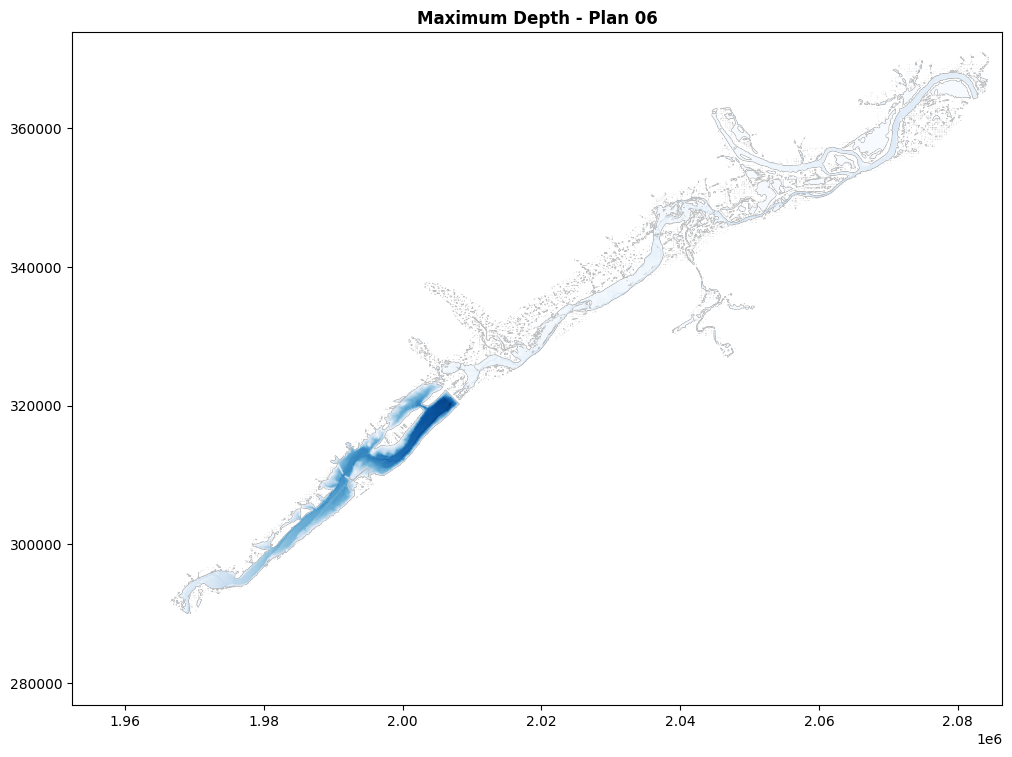

In [9]:
# Find the output directory and the depth map file
plan_info = ras.plan_df[ras.plan_df['plan_number'] == plan_number].iloc[0]
short_id = plan_info.get('Short Identifier', f'Plan_{plan_number}')
output_folder = ras.project_folder / short_id

# HEC-RAS creates a VRT file that points to the actual TIF(s)
depth_map_path = output_folder / "Depth (Max).vrt"

if depth_map_path.exists():
    print(f"Found depth map at: {depth_map_path}")

    # Open and plot the raster using rasterio
    with rasterio.open(depth_map_path) as src:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        show(src, ax=ax, cmap='Blues', title=f'Maximum Depth - Plan {plan_number}')
        plt.show()
else:
    print(f"Could not find the generated depth map at {depth_map_path}")

## Conclusion

This notebook demonstrated how to use the `RasMap.postprocess_stored_maps` function to automate a critical post-processing step. By programmatically generating stored maps, you can easily create the necessary outputs for all your plans without manual intervention in the RASMapper interface, significantly speeding up workflows that involve multiple scenarios or models.